# Aviation's contribution to global warming: Projections to 2050

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 0. Packages, paths and functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import leastsq

# FAIR CLIMATE MODEL
from fair.forward import fair_scm
from fair.RCPs import rcp26, rcp45, rcp60

# change the path  that points to the repository
# path = "C:\Users\galla\Documents\University Physics\Fourth Year Notes\MPhys_Project\2020_12_01InitialPaper\FlyingClimate-main\FlyingClimate-main\"
path = "~/git/FlyingClimate/"

In [3]:
# function to translate a column named by alphabet
# A,B,C,...AA,AB, etc into an index 0,1,2,...
def ABC2index(S):
    i=0
    for j,s in enumerate(list(S)):
        i += j*26+(ord(s)-65)
    
    return i

## 1. Define constants and factors

In [4]:
# define constants to be used. 
# From sheet 'Time Series' in spreadsheet

# effective radiative forcing (ERF) constants [mW/m^2/unit emission]
ERF = dict()                         # mean
ERFstd = dict()                      # uncertainty 1 standard deviation

# columns V-AD
ERF["O3short"] = 34.44               # ozone shortwave
ERF["CH4"] = -18.69                  # methane
ERF["O3long"] = -9.35                # ozone longwave
ERF["SWV"] = -2.80                   # stratospheric water vapour
ERF["netNOx"] = 5.46                 # nitrogen oxides (net)
ERF["BC"] = 100.67                   # black carbon
ERF["SO4"] = -19.91                  # sulphate
ERF["H2O"] = 0.0052                  # water vapour
ERF["contrail"] = 9.36e-10           # contrail and cirrus clouds [mW/m^2/km]

# other constants
Const = dict()
Const["distance_factor"] = 1.17
Const["total_to_civil"] = 0.95       # fraction
Const["EI_NOx"] = 15.14              # emission i? nitrous oxides [g/kg fuel]
Const["EI_H2O"] = 1231.0             # emission i? water vapour [g/kg fuel]
Const["EI_BC"] = 0.03                # emission i? black carbon [g/kg fuel]
Const["EI_SO2"] = 1.2                # emission i? sulph[g/kg fuel]

# efficacies
efficacy_o3short = 1.37
efficacy_ch4 = 1.18

In [5]:
# Emission indices of nitrous oxides
einox_years = np.arange(1976,2019)
EINOx = np.empty(len(einox_years))

# spot data
EINOx[einox_years == 1976] = 9.8
EINOx[einox_years == 1984] = 11.0
EINOx[einox_years == 1992] = 12.90
EINOx[einox_years == 2000] = 13.80
EINOx[einox_years == 2005] = 14.20
EINOx[einox_years == 2010] = 15.14

# keep constant in the future
EINOx[einox_years > 2010] = EINOx[einox_years == 2010]

# interpolate in between
for p in [(1976,1984),(1984,1992),(1992,2000),(2000,2005),(2005,2010)]:
    period = (einox_years >= p[0])*(einox_years <= p[1])
    slope = np.diff(EINOx[period][[-1,0]])[0]/ \
                    np.diff(einox_years[period][[-1,0]])[0]
    EINOx[period] = slope*(einox_years[period]-einox_years[period][0]) + \
                    EINOx[period][0]

## 2. Read in data from CSV

In [6]:
### read in the data
fuel_usage = pd.read_csv(path+"data/fuel_co2.csv")
years = fuel_usage["year"]

In [7]:
fuel_usage

,year,Fuel [Tg/yr],CO2 [Tg/yr],distance [million km]
0,1980,128.732000,406.793120,9350.000000
1,1981,126.552000,399.904320,9113.000000
2,1982,128.181000,405.051960,9140.000000
3,1983,130.347000,411.896520,9395.000000
4,1984,139.045000,439.382200,10102.000000
5,1985,143.439000,453.267240,10598.000000
6,1986,151.484000,478.689440,11491.000000
7,1987,158.448000,500.695680,12266.000000
8,1988,166.128000,524.964480,13017.000000
9,1989,172.991000,546.651560,13493.000000


## 3. Emissions per year 1980-2018

In [8]:
fuel = fuel_usage["Fuel [Tg/yr]"]

# conversion factor Terragram [1e12] to kilogram [1e3]
Tg2kg = 1e9
g2Tg = 1e12
g2kg = 1e-3

# CO2 emissions from flying per year
co2 = fuel_usage["CO2 [Tg/yr]"]

# total flown distance in [km]
scaled_distance = fuel_usage["distance [million km]"]*Const["distance_factor"]*1e6

# black carbon emissions [Tg/yr]
bc = fuel*(Const["EI_BC"]*g2kg)*Const["total_to_civil"]

# sulphur dioxide emissions [Tg/yr]
so2 = fuel*(Const["EI_SO2"]*g2kg)*Const["total_to_civil"]

# nitrogen oxide emissions [cut off year 1976-1979 from EINOx]
nox = fuel*(EINOx[einox_years > 1979]*g2kg)*Const["total_to_civil"]*(14/46)  # WHY 14/46?

# water vapour
h2o = fuel*(Const["EI_H2O"]*g2kg)*Const["total_to_civil"]

In [9]:
# million litres of aviation fuel burned every day in 2018
fuel[38]*Tg2kg/0.8 / 365.25/ 1e9

1.1195087085420945

## 4.1 Radiative forcings of CO2 via FAIR, 1940-2018

CO2 emissions from aviation extrapolated back to 1940 at 3% increase per year

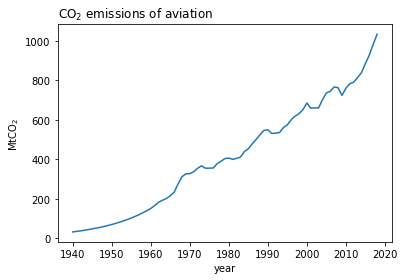

In [10]:
co2_1940 = np.zeros(2018-1940+1)
co2_1940[40:] = co2    # set the 1980 to 2018 values
    
DF_CO2_1940 = pd.read_csv(path+"data/co2_1940.csv")
co2_1940[:40] = DF_CO2_1940["CO2 [Tg/yr]"]

plt.plot(np.arange(1940,2019),co2_1940)
plt.title(r"CO$_2$ emissions of aviation",loc="left")
plt.ylabel(r"MtCO$_2$")
plt.xlabel("year");

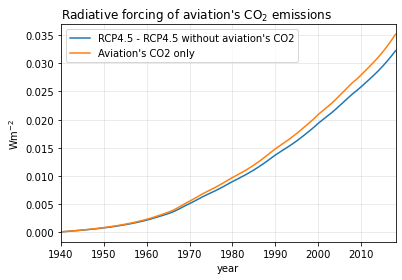

In [11]:
# RUN FAIR
rcp_years = rcp26.Emissions.year
co2_1765 = np.zeros(len(rcp_years))
co2_1765[(rcp_years > 1939)*(rcp_years < 2019)] = co2_1940/1000*(12/44)

# control simulations: RCP4.5 as baseline (doesn't change with RCP2.6,6.0 as only 1940-2018 is considered here)
emissions26 = rcp26.Emissions.emissions.copy()
emissions45 = rcp45.Emissions.emissions.copy()
emissions60 = rcp60.Emissions.emissions.copy()

C26,F26,T26 = fair_scm(emissions=emissions26)
C45,F45,T45 = fair_scm(emissions=emissions45)
C60,F60,T60 = fair_scm(emissions=emissions60)

# create NO-AVIATION scenarios from RCP scenarios
emissions45[:,1] -= co2_1765

t1940 = np.int(1940-rcp_years[0])
t1980 = np.int(1980-rcp_years[0])
t2018 = np.int(2019-rcp_years[0])
t2050 = np.int(2050-rcp_years[0])
C45noav, F45noav, T45noav= fair_scm(emissions=emissions45)

# only aviation emissions
Cav_only, Fav_only, Tav_only = fair_scm(emissions=co2_1765,useMultigas=False)

plt.plot(rcp_years[t1940:t2018],(F45-F45noav)[t1940:t2018,0],label="RCP4.5 - RCP4.5 without aviation's CO2")
plt.plot(rcp_years[t1940:t2018],Fav_only[t1940:t2018],label="Aviation's CO2 only")

plt.title(r"Radiative forcing of aviation's CO$_2$ emissions",loc="left")
plt.legend()
plt.xlim(1940,2018)
plt.grid(alpha=0.3)
plt.xlabel("year")
plt.ylabel(r"Wm$^{-2}$");

In [12]:
t1980 = np.int(1980-rcp_years[0])

# multi scenario mean [mW/m^2]
co2rf_1940 = (F45-F45noav)[t1940:t2018,0]*1000
co2rf_1980 = (F45-F45noav)[t1980:t2018,0]*1000
co2ppm_1940 = (C45-C45noav)[t1940:t2018,0]
years_1940 = rcp_years[t1940:t2018]

DF = pd.DataFrame(np.vstack((years_1940,co2ppm_1940,co2rf_1940)).T,columns=["year","CO2 ppm","CO2 RF [mW/m^2]"])
DF['year'] = DF['year'].astype(int)
# DF.to_csv("../data/CO2_radiative_forcing_FAIR.csv",float_format = "%.4f")

In [13]:
co2rf_1940

array([ 0.07179661,  0.13347958,  0.19332939,  0.25438809,  0.31797716,
        0.38498608,  0.45581658,  0.53096618,  0.61106459,  0.69675598,
        0.78816259,  0.88566714,  0.99010709,  1.1021017 ,  1.2222412 ,
        1.35098576,  1.48931361,  1.63840133,  1.79923082,  1.97282657,
        2.15961407,  2.36626197,  2.59482577,  2.82840683,  3.06131139,
        3.30940924,  3.58188662,  3.92913003,  4.32587751,  4.72256951,
        5.09767286,  5.4794978 ,  5.88156142,  6.28772043,  6.65551347,
        7.0181191 ,  7.3706973 ,  7.76174603,  8.16744995,  8.58661648,
        9.00133141,  9.39413761,  9.79059301, 10.19009314, 10.62688882,
       11.07489535, 11.55966029, 12.06985343, 12.60775846, 13.16942863,
       13.72009515, 14.22135067, 14.71637081, 15.19074021, 15.70624576,
       16.24261989, 16.82124436, 17.42150576, 18.03256548, 18.67033271,
       19.35299893, 19.96527417, 20.57071542, 21.16190404, 21.81405302,
       22.50828081, 23.19684228, 23.90560349, 24.58812123, 25.18

## 4.2 Effective radiative forcings of O3, CH4, SWV, netNOX, BC, SO4, H20, contrails

In [14]:
o3short_rf = nox*ERF["O3short"]
ch4_rf = nox*ERF["CH4"]
o3long_rf = nox*ERF["O3long"]
swv_rf = nox*ERF["SWV"]
bc_rf = bc*ERF["BC"]
so4_rf = so2*ERF["SO4"]     # SO2 vs SO4, correct?
h2o_rf = h2o*ERF["H2O"]
contrail_rf = scaled_distance*ERF["contrail"]

## 5. Sum non-CO2 radiative forcings

In [15]:
nonCO2_rf = o3short_rf + ch4_rf + o3long_rf + swv_rf + bc_rf + so4_rf + h2o_rf + contrail_rf

## 6. Plot individual ERFs for aviation

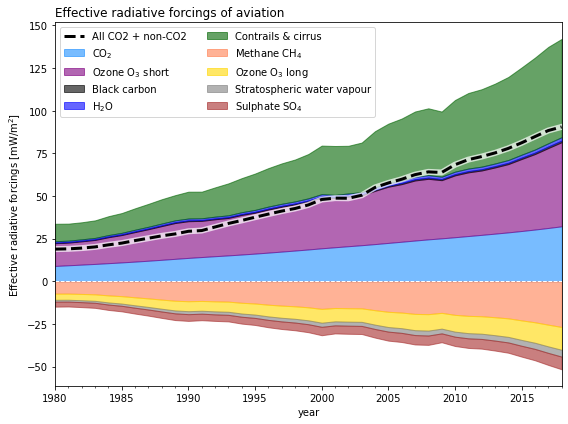

In [16]:
years = fuel_usage["year"]

fig,ax1 = plt.subplots(1,1,figsize=(8,6),sharex=True)

alfa=0.6
# pack all radiative forcings in one array
all_positive_rfs = np.array([np.zeros_like(years),
                             co2rf_1980,
                             o3short_rf,
                             bc_rf,
                             h2o_rf,
                             contrail_rf])

all_negative_rfs = np.array([np.zeros_like(years),
                             ch4_rf,
                             o3long_rf,
                             swv_rf,
                             so4_rf])

rf_posnames = [r"CO$_2$",r"Ozone O$_3$ short","Black carbon",r"H$_2$O","Contrails & cirrus"]
rf_negnames = [r"Methane CH$_4$",r"Ozone O$_3$ long","Stratospheric water vapour",r"Sulphate SO$_4$"]
poscolours = ["","dodgerblue","purple","k","blue","darkgreen","red"]
negcolours = ["","coral","gold","grey","brown"]
for i in range(1,all_positive_rfs.shape[0]):
    ax1.fill_between(years,
                     np.sum(all_positive_rfs[:i+1,:],axis=0),
                     np.sum(all_positive_rfs[:i,:],axis=0),
                     alpha=alfa,label=rf_posnames[i-1],
                     edgecolor="white",color=poscolours[i])
    
for i in range(1,all_negative_rfs.shape[0]):
    ax1.fill_between(years,
                     np.sum(all_negative_rfs[:i+1,:],axis=0),
                     np.sum(all_negative_rfs[:i,:],axis=0),
                     alpha=alfa,label=rf_negnames[i-1],
                     edgecolor="white",color=negcolours[i])

ax1.plot(years,np.sum(all_negative_rfs,axis=0)+np.sum(all_positive_rfs,axis=0),"w",lw=6,alpha=0.7)
ax1.plot(years,np.sum(all_negative_rfs,axis=0)+np.sum(all_positive_rfs,axis=0),"k--",lw=3,label="All CO2 + non-CO2")
ax1.plot(years,np.zeros_like(years),"w--",lw=1)
    
ax1.set_title("Effective radiative forcings of aviation",loc="left")
ax1.legend(loc=2,ncol=2)

ax1.set_ylabel(r"Effective radiative forcings [mW/m$^2$]")
ax1.set_xlabel("year")

ax1.set_xlim(1980,2018)
# ax1.set_ylim(0,ax1.get_ylim()[1])
ax1.set_xticks(years,minor=True)
plt.tight_layout()
# plt.savefig("../plots/radiative_forcings_nonCO2.pdf")

## 8. COVID-motivated emission scenarios

In [17]:
# load opensky flight data
opensky_file = pd.read_csv(path+"data/Opensky_EURO_2019_2020.csv")
dates_os = opensky_file["Date"]
nflights_global = opensky_file["N_Aircraft_Global"].to_numpy()
nflights_europe = opensky_file["N_Flights_EURO"]

# convert "23,123" to 23123 of type np.int
nflights_europe = np.array([np.int(n.split(",")[0] + n.split(",")[1]) for n in nflights_europe])

In [18]:
import datetime
dates = [0,]*len(dates_os)

for i in range(len(dates_os)):
    day,month,year = dates_os[i].split("/")
    dates[i] = datetime.date(np.int(year),np.int(month),np.int(day))
    
dayssince2019 = np.array([(d-datetime.date(2019,1,1)).days for d in dates])

daystill2030 = np.arange(15*365)
datestill2030 = [datetime.date(2019,1,1)+datetime.timedelta(int(d)) for d in daystill2030]

# indices in dates lists that correspond to the respective dates
march1 = [i for i in range(len(datestill2030)) if datestill2030[i] == datetime.date(2020,3,1)][0]
jan1 = [i for i in range(len(datestill2030)) if datestill2030[i] == datetime.date(2020,1,1)][0]
jan1_2021 = [i for i in range(len(datestill2030)) if datestill2030[i] == datetime.date(2021,1,1)][0]
jan1_2024 = [i for i in range(len(datestill2030)) if datestill2030[i] == datetime.date(2024,1,1)][0]

# 3% annual increase model
def peval(x, p):
    return p[0] * 1.03**(x/365.25)

def residuals(p,y,x):
    return y - peval(x,p)

# least square fitting of the 3% increase model
p0 = [0]
plsq2019 = leastsq(residuals, p0, args=(nflights_global[:march1], dayssince2019[:march1]))
plsq2020 = np.mean(nflights_global[march1:])

# no covid scenario
nflights_nocovid = peval(daystill2030,plsq2019[0])

# scenarios covid + recovery until 2025 + incline/const/decline after 2025
nflights_recovery = plsq2020*np.ones_like(daystill2030)
nflights_recovery_const = plsq2020*np.ones_like(daystill2030)
nflights_recovery_decline = plsq2020*np.ones_like(daystill2030)

# set 2019 data to 3% incline for all these scenarios
nflights_recovery[daystill2030 < 365] = nflights_nocovid[daystill2030 < 365]
nflights_recovery_const[daystill2030 < 365] = nflights_nocovid[daystill2030 < 365]
nflights_recovery_decline[daystill2030 < 365] = nflights_nocovid[daystill2030 < 365]

# what to do in the recovery period 2021-2025
p_rec1 = 18
p_rec2 = 14
p_rec3 = 10

j = 1
for i in range(jan1_2021,jan1_2024):
    nflights_recovery[i] = nflights_recovery[jan1_2021-1]*(1+p_rec1/100)**(j/365.25)
    nflights_recovery_const[i] = nflights_recovery[jan1_2021-1]*(1+p_rec2/100)**(j/365.25)
    nflights_recovery_decline[i] = nflights_recovery[jan1_2021-1]*(1+p_rec3/100)**(j/365.25)
    j += 1
    
# what to do until 2050
p_after1 = 3
p_after2 = 0
p_after3 = -2

j = 1
for i in range(jan1_2024,len(datestill2030)):
    nflights_recovery[i] = nflights_recovery[jan1_2024-1]*(1+p_after1/100)**(j/365.25)
    nflights_recovery_const[i] = nflights_recovery_const[jan1_2024-1]*(1+p_after2/100)**(j/365.25)
    nflights_recovery_decline[i] = nflights_recovery_decline[jan1_2024-1]*(1+p_after3/100)**(j/365.25)
    j+=1


In [19]:
# CO2 emissions for scenarios
years_future = np.arange(2018,2051)
co2_scenario1 = np.zeros(len(years_future))     # decline scenario
co2_scenario2 = np.zeros(len(years_future))     # const scenario
co2_scenario3 = np.zeros(len(years_future))     # incline scenario
co2_scenario4 = np.zeros(len(years_future))     # nocovid scenario

# copy 2018 data
co2_scenario1[0] = co2[years == 2018]
co2_scenario2[0] = co2[years == 2018]
co2_scenario3[0] = co2[years == 2018]
co2_scenario4[0] = co2[years == 2018]

# always 3% increase for nocovid scenario
for i in range(1,len(years_future)): 
    co2_scenario4[i] = co2_scenario4[i-1]*(1+p_after1/100)

# 3% increase in 2019 for all
co2_scenario1[1] = co2[years == 2018]*(1+p_after1/100)
co2_scenario2[1] = co2[years == 2018]*(1+p_after1/100)
co2_scenario3[1] = co2[years == 2018]*(1+p_after1/100)

# 40% drop in 2020 for all but no-covid scenario
covid_drop = 40
co2_scenario1[2] = co2_scenario1[1]*(1-covid_drop/100)
co2_scenario2[2] = co2_scenario2[1]*(1-covid_drop/100)
co2_scenario3[2] = co2_scenario3[1]*(1-covid_drop/100)

# recovery period
for i in range(3,6):   # 2021,2022,2023
    co2_scenario1[i] = co2_scenario1[i-1]*(1+p_rec3/100)
    co2_scenario2[i] = co2_scenario2[i-1]*(1+p_rec2/100)
    co2_scenario3[i] = co2_scenario3[i-1]*(1+p_rec1/100)
    
# after that till 2050 period
for i in range(6,len(years_future)):   # 2021,2022,2023
    co2_scenario1[i] = co2_scenario1[i-1]*(1+p_after3/100)
    co2_scenario2[i] = co2_scenario2[i-1]*(1+p_after2/100)
    co2_scenario3[i] = co2_scenario3[i-1]*(1+p_after1/100)

## 9. Non-CO2 radiative forcing: Aviation's contribution to global warming

In [20]:
# projections into the future
years_future = np.arange(2018,2051)
nonco2rf_scenario1 = np.zeros(len(years_future))     # COVID recovery at  7%, 1.4% decline per year after 2025
nonco2rf_scenario2 = np.zeros(len(years_future))     # COVID recovery at 10%, constant after 2025
nonco2rf_scenario3 = np.zeros(len(years_future))     # COVID recovery at 13%, 3% incline per year after 2025
nonco2rf_scenario4 = np.zeros(len(years_future))     # No COVID: 3% incline per year

nonco2rf_scenario1[0] = nonCO2_rf[years == 2018]
nonco2rf_scenario2[0] = nonCO2_rf[years == 2018]
nonco2rf_scenario3[0] = nonCO2_rf[years == 2018]
nonco2rf_scenario4[0] = nonCO2_rf[years == 2018]

# for 2019 set all scenarios to 3% incline scenario
percent_incline = 3
for scenario in [nonco2rf_scenario1,nonco2rf_scenario2,nonco2rf_scenario3,nonco2rf_scenario4]:
    scenario[1] = scenario[0]*(1+percent_incline/100)
    
# 3% continous incline for non covid scenario till 2050
for i in range(2,len(years_future)):
    nonco2rf_scenario4[i] = nonco2rf_scenario4[i-1]*(1+percent_incline/100)

# 40% drop in 2020 for all but no-covid scenario
covid_drop = 40
for scenario in [nonco2rf_scenario1,nonco2rf_scenario2,nonco2rf_scenario3]:
    scenario[2] = scenario[1]*(1-covid_drop/100)

# recovery period
for i in range(3,6):   # 2021,2022,2023,2024
    nonco2rf_scenario1[i] = nonco2rf_scenario1[i-1]*(1+p_rec3/100)
    nonco2rf_scenario2[i] = nonco2rf_scenario2[i-1]*(1+p_rec2/100)
    nonco2rf_scenario3[i] = nonco2rf_scenario3[i-1]*(1+p_rec1/100)
    
    
# after that till 2050 period
for i in range(6,len(years_future)):   # 2021,2022,2023,2024
    nonco2rf_scenario1[i] = nonco2rf_scenario1[i-1]*(1+p_after3/100)
    nonco2rf_scenario2[i] = nonco2rf_scenario2[i-1]*(1+p_after2/100)
    nonco2rf_scenario3[i] = nonco2rf_scenario3[i-1]*(1+p_after1/100)
    

In [21]:
# Cumulative CO2 forcing-equivalent emissions of non-CO2 effects

r = 0.25          # BB6, transient correction factor
AGWP100 = 91.7    # Absolute global warming potential [1], BB7 OF WHAT?
H = 100.0         # BB8, WHAT'S THIS?
TCRE = 0.00045    # Transient climate response to cumulative
                  # carbon emissions [K/GtCO2], BB9

# CO2 forcing-equivalent emissions (historic)
nonCO2_rf0 = 0 #nonCO2_rf[0]
years0 = 1940
nonCO2_cumemissions = (1-r)*(H/AGWP100)*(nonCO2_rf - nonCO2_rf0) + (r/AGWP100)*nonCO2_rf*(years-years0)

# future scenarios for nonCO2_warming
nonco2_cumemiss_scenario1 = (1-r)*(H/AGWP100)*(nonco2rf_scenario1 - nonCO2_rf0) +\
                            (r/AGWP100)*nonco2rf_scenario1*(years_future-years0)

nonco2_cumemiss_scenario2 = (1-r)*(H/AGWP100)*(nonco2rf_scenario2 - nonCO2_rf0) +\
                            (r/AGWP100)*nonco2rf_scenario2*(years_future-years0)

nonco2_cumemiss_scenario3 = (1-r)*(H/AGWP100)*(nonco2rf_scenario3 - nonCO2_rf0) +\
                            (r/AGWP100)*nonco2rf_scenario3*(years_future-years0)

nonco2_cumemiss_scenario4 = (1-r)*(H/AGWP100)*(nonco2rf_scenario4 - nonCO2_rf0) +\
                            (r/AGWP100)*nonco2rf_scenario4*(years_future-years0)


# equivalent warming CO2+NON-CO2
warming_scenario1 = TCRE*(nonco2_cumemiss_scenario1+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario1)/1000)
warming_scenario2 = TCRE*(nonco2_cumemiss_scenario2+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario2)/1000)
warming_scenario3 = TCRE*(nonco2_cumemiss_scenario3+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000)
warming_scenario4 = TCRE*(nonco2_cumemiss_scenario4+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario4)/1000)

# CO2 only warming
co2warm_scenario1 = TCRE*(np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario1)/1000)
co2warm_scenario2 = TCRE*(np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario2)/1000)
co2warm_scenario3 = TCRE*(np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000)
co2warm_scenario4 = TCRE*(np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario4)/1000)

Warming in 2019

In [22]:
T = warming_scenario3[-1]
ΔT0 = T*(55/100.9)
ΔT1 = T*(145/100.9)

"Warming in 2019: {:.3f}˚C ({:.3f}-{:.3f}˚C)".format(T,ΔT0,ΔT1)

'Warming in 2019: 0.103˚C (0.056-0.147˚C)'

## 10. Main figure

Text(2050.5, 492.79392430368665, 'Long-Term Decline\n-2%/year after 2024')

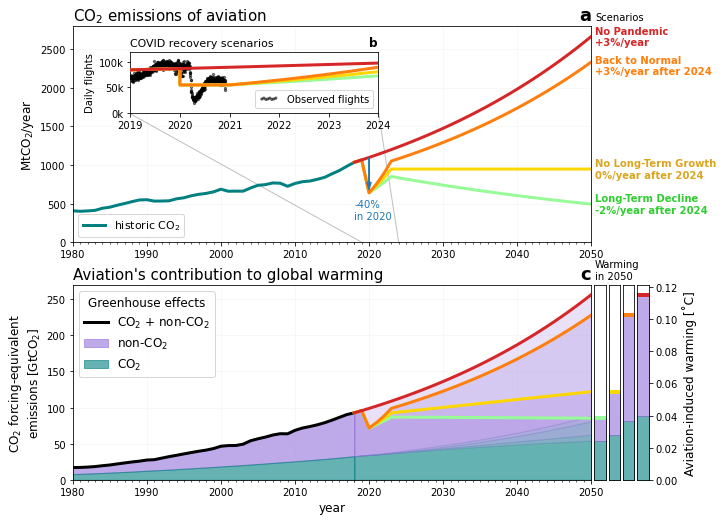

In [23]:
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_axes([0,0.55,0.9,0.5])
ax3 = fig.add_axes([0,0,0.9,0.45])

# covid response inlay axis
ax = fig.add_axes([0.1,0.85,0.43,0.14])

# scenario axes
pos = ax3.get_position()
ax_s1 = fig.add_axes([pos.x1+0.005,pos.y0,0.02,pos.y1-pos.y0])
ax_s2 = fig.add_axes([pos.x1+0.03,pos.y0,0.02,pos.y1-pos.y0])
ax_s3 = fig.add_axes([pos.x1+0.055,pos.y0,0.02,pos.y1-pos.y0])
ax_s4 = fig.add_axes([pos.x1+0.08,pos.y0,0.02,pos.y1-pos.y0])
ax_s4.yaxis.set_label_position("right")
ax_s4.yaxis.tick_right()

ax.plot(datestill2030,nflights_nocovid/1000,"C3",lw=3,zorder=10)
ax.plot(datestill2030,nflights_recovery/1000,"C1",lw=3,zorder=9)
ax.plot(datestill2030,nflights_recovery_const/1000,"gold",lw=3,zorder=8)
ax.plot(datestill2030,nflights_recovery_decline/1000,"palegreen",lw=3,zorder=7)

ax.scatter(dates,nflights_global/1000,5,color="k",alpha=0.5,label="Observed flights",zorder=-1)

ax.yaxis.set_major_formatter(FormatStrFormatter('%d'+'k'))
ax.set_ylabel("Daily flights")
ax.set_xlim(datetime.date(2019,1,1),datetime.date(2024,1,1))
ax.set_ylim(0,120)
ax.legend(loc=4,scatterpoints=8)
ax.set_title("COVID recovery scenarios",loc="left",fontsize=11)
ax.set_title("b",loc="right",fontweight="bold")

ax.xaxis.set_minor_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# lines for orientation
ax1.plot([2024,2021.3],[0,1660],"grey",lw=1,alpha=0.5)
ax1.plot([2019,1987.8],[0,1660],"grey",lw=1,alpha=0.5)
ax1.arrow(2020,co2_scenario4[years_future==2020][0],
          0,0.7*(co2_scenario1[years_future==2020]-co2_scenario4[years_future==2020])[0],
          width=0.1,zorder=12,color="C0",head_width=0.6,head_length=100)
ax1.text(2018,300,"-40%\nin 2020",color="C0")

# historic
ax1.plot(years,co2,"teal",lw=3,label=r"historic CO$_2$")

# future scenarios
ax1.plot(years_future,co2_scenario4,"C3",lw=3,zorder=11)
ax1.plot(years_future,co2_scenario3,"C1",lw=3,zorder=10)
ax1.plot(years_future,co2_scenario2,"gold",lw=3,zorder=9)
ax1.plot(years_future,co2_scenario1,"palegreen",lw=3,zorder=8)

ax1.set_title(r"CO$_2$ emissions of aviation",loc="left",fontsize=15)
ax1.set_title("a",loc="right",fontweight="bold",fontsize=18)
ax3.set_title("c",loc="right",fontweight="bold",fontsize=18)

ax1.set_ylabel(r"MtCO$_2$/year",fontsize=12)
ax1.set_xlim(1980,2050)
ax3.set_xlim(1980,2050)
ax1.set_ylim(0,ax1.get_ylim()[1])

ax1.set_xticks(np.hstack((years,years_future)),minor=True)
ax3.set_xticks(np.hstack((years,years_future)),minor=True)

# FORCING-EQUIVALENT EMISSIONS
# historic
alfa=0.6
h4 = lambda y: 1-np.sqrt(np.sqrt(1-y))  # four-level superimposed alpha

# cumulative
cumco2_1940 = np.cumsum(co2_1940)[40:]/1000
ax3.fill_between(years,nonCO2_cumemissions+cumco2_1940,cumco2_1940,alpha=alfa,color="mediumpurple",label="non-CO$_2$")
ax3.fill_between(years,cumco2_1940,alpha=alfa,color="teal",label=r"CO$_2$")
ax3.plot(years,nonCO2_cumemissions+cumco2_1940,"k",lw=3,label=r"CO$_2$ + non-CO$_2$")

# cumulative future
# CO2
# ax3.fill_between(years_future,np.ones_like(years_future)*np.sum(co2)/1000,alpha=h4(alfa),color="teal")
ax3.fill_between(years_future,np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario1)/1000,
                 alpha=h4(alfa),color="teal")
ax3.fill_between(years_future,np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario2)/1000,
                 alpha=h4(alfa),color="teal")
ax3.fill_between(years_future,np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000,
                 alpha=h4(alfa),color="teal")
ax3.fill_between(years_future,np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario4)/1000,
                 alpha=h4(alfa),color="teal")

# NON-CO2
ax3.plot(years_future,(nonco2_cumemiss_scenario4+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario4)/1000),
         "C3",lw=3,zorder=11)
ax3.plot(years_future,(nonco2_cumemiss_scenario3+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000),
         "C1",lw=3,zorder=10)
ax3.plot(years_future,(nonco2_cumemiss_scenario2+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario2)/1000),
         "gold",lw=3,zorder=9)
ax3.plot(years_future,(nonco2_cumemiss_scenario1+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario1)/1000),
         "palegreen",lw=3,zorder=8)

ax3.fill_between(years_future,nonco2_cumemiss_scenario1+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario1)/1000,
                 np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario1)/1000,
                 alpha=h4(alfa),color="mediumpurple")
ax3.fill_between(years_future,nonco2_cumemiss_scenario2+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario2)/1000,
                 np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario2)/1000,
                 alpha=h4(alfa),color="mediumpurple")
ax3.fill_between(years_future,nonco2_cumemiss_scenario3+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000,
                 np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000,
                 alpha=h4(alfa),color="mediumpurple")
ax3.fill_between(years_future,nonco2_cumemiss_scenario4+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario4)/1000,
                 np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario4)/1000,
                 alpha=h4(alfa),color="mediumpurple")

# SCENARIO COMPARISON 2050
ax_s1.axhline(warming_scenario1[-1],color="palegreen",lw=4)
ax_s2.axhline(warming_scenario2[-1],color="gold",lw=4)
ax_s3.axhline(warming_scenario3[-1],color="C1",lw=4)
ax_s4.axhline(warming_scenario4[-1],color="C3",lw=4)

ax_s1.fill_between([0,1],np.ones(2)*co2warm_scenario1[-1],color="teal",alpha=alfa)
ax_s2.fill_between([0,1],np.ones(2)*co2warm_scenario2[-1],color="teal",alpha=alfa)
ax_s3.fill_between([0,1],np.ones(2)*co2warm_scenario3[-1],color="teal",alpha=alfa)
ax_s4.fill_between([0,1],np.ones(2)*co2warm_scenario4[-1],color="teal",alpha=alfa)

ax_s1.fill_between([0,1],np.ones(2)*warming_scenario1[-1],np.ones(2)*co2warm_scenario1[-1],color="mediumpurple",alpha=alfa)
ax_s2.fill_between([0,1],np.ones(2)*warming_scenario2[-1],np.ones(2)*co2warm_scenario2[-1],color="mediumpurple",alpha=alfa)
ax_s3.fill_between([0,1],np.ones(2)*warming_scenario3[-1],np.ones(2)*co2warm_scenario3[-1],color="mediumpurple",alpha=alfa)
ax_s4.fill_between([0,1],np.ones(2)*warming_scenario4[-1],np.ones(2)*co2warm_scenario4[-1],color="mediumpurple",alpha=alfa)

ax3.set_title(r"Aviation's contribution to global warming",loc="left",fontsize=15)

ax3.set_ylabel(r"CO$_2$ forcing-equivalent"+"\n"+"emissions [GtCO$_2$]",fontsize=12)
ax_s4.set_ylabel("Aviation-induced warming [˚C]",fontsize=12)
ax3.set_xlabel("year",fontsize=12)
ax1.legend(loc=3,fontsize=11)
ax3.legend(loc=2,title="Greenhouse effects",fontsize=12,title_fontsize='large')

ax3.set_ylim(0,ax3.get_ylim()[1])
for ax in [ax_s1,ax_s2,ax_s3,ax_s4]:
    ax.set_ylim(0,TCRE*ax3.get_ylim()[1])
    ax.set_xlim(0,1)

for ax in [ax_s1,ax_s2,ax_s3]:
    ax.set_yticks([])
    ax.set_xticks([])

ax_s4.set_xticks([])

ax1.grid(alpha=0.1)
ax3.grid(alpha=0.1)
ax1.text(2050.5,ax1.get_ylim()[1]*1.03,"Scenarios")
ax3.text(2050.5,ax3.get_ylim()[1]*1.035,"Warming\nin 2050")
ax1.text(2050.5,co2_scenario4[-1],"No Pandemic\n+3%/year",color="C3",fontweight="bold",va="center")
ax1.text(2050.5,co2_scenario3[-1]*0.98,"Back to Normal\n+3%/year after 2024",color="C1",fontweight="bold",va="center")
ax1.text(2050.5,co2_scenario2[-1],"No Long-Term Growth\n0%/year after 2024",color="goldenrod",fontweight="bold",va="center")
ax1.text(2050.5,co2_scenario1[-1],"Long-Term Decline\n-2%/year after 2024",color="limegreen",fontweight="bold",va="center")

# plt.savefig("../plots/emissions_warming.pdf")

In [24]:
warming_scenario4

array([0.04171197, 0.04307544, 0.04448201, 0.04593306, 0.04742998,
       0.04897422, 0.05056728, 0.05221069, 0.05390604, 0.05565497,
       0.05745916, 0.05932036, 0.06124037, 0.06322103, 0.06526427,
       0.06737204, 0.06954639, 0.07178941, 0.07410327, 0.0764902 ,
       0.07895249, 0.08149253, 0.08411275, 0.08681569, 0.08960396,
       0.09248023, 0.09544728, 0.09850797, 0.10166524, 0.10492214,
       0.10828179, 0.11174745, 0.11532243])

## 11. Supplementary figures
Run FAIR with scenario 1-4 to obtain CO2 forcings till 2050

In [25]:
# combine historic CO2 since 1940 with scenarios
co2_1940_scenario1 = np.hstack((co2_1940,co2_scenario1[1:]))
co2_1940_scenario2 = np.hstack((co2_1940,co2_scenario2[1:]))
co2_1940_scenario3 = np.hstack((co2_1940,co2_scenario3[1:]))
co2_1940_scenario4 = np.hstack((co2_1940,co2_scenario4[1:]))

rcp_years = rcp26.Emissions.year
co2_1765_scenario1 = np.zeros(len(rcp_years))
co2_1765_scenario2 = np.zeros(len(rcp_years))
co2_1765_scenario3 = np.zeros(len(rcp_years))
co2_1765_scenario4 = np.zeros(len(rcp_years))

# aviation emissions for various scenarios, convert from MtCO2 to GtC
mass_ratio = (12/44)    # 12g/mol for C, 44g/mol for CO2 (12+2*16)
co2_1765_scenario1[(rcp_years > 1939)*(rcp_years < 2051)] = co2_1940_scenario1/1000*mass_ratio
co2_1765_scenario2[(rcp_years > 1939)*(rcp_years < 2051)] = co2_1940_scenario2/1000*mass_ratio
co2_1765_scenario3[(rcp_years > 1939)*(rcp_years < 2051)] = co2_1940_scenario3/1000*mass_ratio
co2_1765_scenario4[(rcp_years > 1939)*(rcp_years < 2051)] = co2_1940_scenario4/1000*mass_ratio

t2018 = np.int(2018-rcp_years[0])
t2050 = np.int(2051-rcp_years[0])
co2rf_2050_all_scenarios = np.zeros((3,4,t2050-t2018))
temp_2050_all_scenarios = np.zeros((3,4,t2050-t2018))

for isc,scenario in enumerate([co2_1765_scenario1,\
                               co2_1765_scenario2,\
                               co2_1765_scenario3,\
                               co2_1765_scenario4]):
    
    # control simulations: RCP2.6 4.5, 6.0 as baseline
    emissions26 = rcp26.Emissions.emissions.copy()
    emissions45 = rcp45.Emissions.emissions.copy()
    emissions60 = rcp60.Emissions.emissions.copy()

    # create NO-AVIATION scenarios from RCP scenarios
    emissions26[:,1] -= scenario
    emissions45[:,1] -= scenario
    emissions60[:,1] -= scenario

    # RUN FAIR
    C26noav, F26noav, T26noav = fair_scm(emissions=emissions26)
    C45noav, F45noav, T45noav = fair_scm(emissions=emissions45)
    C60noav, F60noav, T60noav = fair_scm(emissions=emissions60)

    co2rf_2050_all_scenarios[0,isc,:] = (F26-F26noav)[t2018:t2050,0]
    co2rf_2050_all_scenarios[1,isc,:] = (F45-F45noav)[t2018:t2050,0]
    co2rf_2050_all_scenarios[2,isc,:] = (F60-F60noav)[t2018:t2050,0]
    
    temp_2050_all_scenarios[0,isc,:] = (T26-T26noav)[t2018:t2050]
    temp_2050_all_scenarios[1,isc,:] = (T45-T45noav)[t2018:t2050]
    temp_2050_all_scenarios[2,isc,:] = (T60-T60noav)[t2018:t2050]
    

In [26]:
# average RCP2.6,4.5 and 6.0
co2rf_2050_all_scenarios_m = co2rf_2050_all_scenarios.mean(axis=0)
temp_2050_all_scenarios_m = temp_2050_all_scenarios.mean(axis=0)

co2rf_scenario1 = 1000*co2rf_2050_all_scenarios_m[0,:]
co2rf_scenario2 = 1000*co2rf_2050_all_scenarios_m[1,:]
co2rf_scenario3 = 1000*co2rf_2050_all_scenarios_m[2,:]
co2rf_scenario4 = 1000*co2rf_2050_all_scenarios_m[3,:]

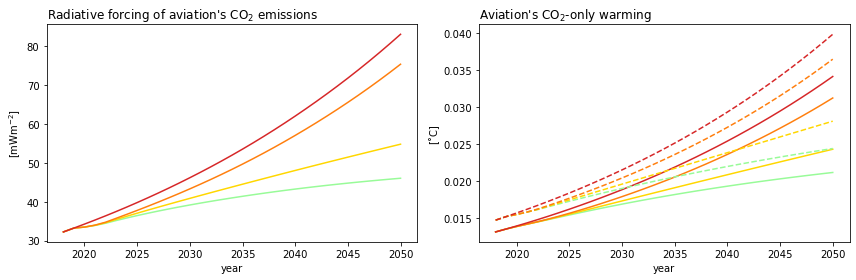

In [27]:
fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(12,4))

ax1.plot(years_future,co2rf_scenario1,"palegreen")
ax1.plot(years_future,co2rf_scenario2,"gold")
ax1.plot(years_future,co2rf_scenario3,"C1")
ax1.plot(years_future,co2rf_scenario4,"C3")

ax2.plot(years_future,temp_2050_all_scenarios_m[0,:],"palegreen")
ax2.plot(years_future,temp_2050_all_scenarios_m[1,:],"gold")
ax2.plot(years_future,temp_2050_all_scenarios_m[2,:],"C1")
ax2.plot(years_future,temp_2050_all_scenarios_m[3,:],"C3")

# TCRE-based as comparison
ax2.plot(years_future,co2warm_scenario1,"--",color="palegreen")
ax2.plot(years_future,co2warm_scenario2,"--",color="gold")
ax2.plot(years_future,co2warm_scenario3,"--",color="C1")
ax2.plot(years_future,co2warm_scenario4,"--",color="C3")

ax1.set_xlabel("year")
ax2.set_xlabel("year")
ax1.set_ylabel(r"[mWm$^{-2}$]")
ax2.set_ylabel("[˚C]")
ax1.set_title("Radiative forcing of aviation's CO$_2$ emissions",loc="left")
ax2.set_title("Aviation's CO$_2$-only warming",loc="left")
plt.tight_layout()

In [28]:
cumco2 = np.sum(co2_1940)/1000    # convert to GtCO2
cumco2_scenario1 = np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario1)/1000
cumco2_scenario2 = np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario2)/1000
cumco2_scenario3 = np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000
cumco2_scenario4 = np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario4)/1000

[]

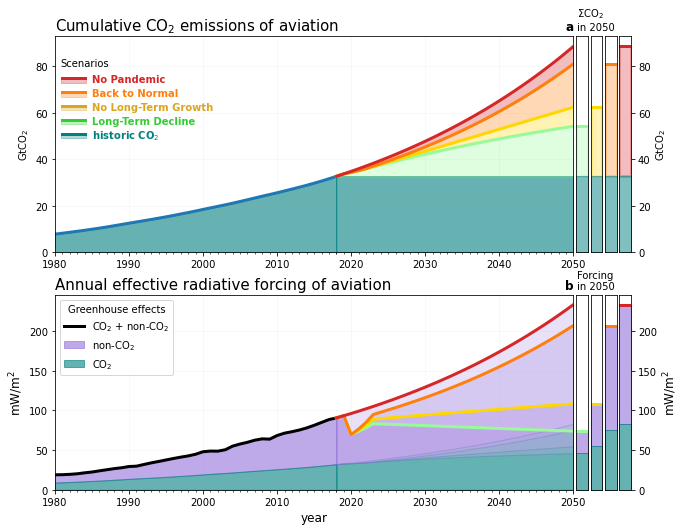

In [29]:
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_axes([0,0.55,0.9,0.5])
ax2 = fig.add_axes([0,0,0.9,0.45])

# scenario axes
pos = ax1.get_position()
ax1_s1 = fig.add_axes([pos.x1+0.005,pos.y0,0.02,pos.y1-pos.y0])
ax1_s2 = fig.add_axes([pos.x1+0.03,pos.y0,0.02,pos.y1-pos.y0])
ax1_s3 = fig.add_axes([pos.x1+0.055,pos.y0,0.02,pos.y1-pos.y0])
ax1_s4 = fig.add_axes([pos.x1+0.08,pos.y0,0.02,pos.y1-pos.y0])

pos = ax2.get_position()
ax2_s1 = fig.add_axes([pos.x1+0.005,pos.y0,0.02,pos.y1-pos.y0])
ax2_s2 = fig.add_axes([pos.x1+0.03,pos.y0,0.02,pos.y1-pos.y0])
ax2_s3 = fig.add_axes([pos.x1+0.055,pos.y0,0.02,pos.y1-pos.y0])
ax2_s4 = fig.add_axes([pos.x1+0.08,pos.y0,0.02,pos.y1-pos.y0])

ax1_s4.yaxis.set_label_position("right")
ax2_s4.yaxis.set_label_position("right")
ax1_s4.yaxis.tick_right()
ax2_s4.yaxis.tick_right()

# historic
ax1.fill_between(years_1940,np.cumsum(co2_1940)/1000,alpha=0.6,color="teal")
ax1.plot(years_1940,np.cumsum(co2_1940)/1000,lw=3)

# future scenarios
alfa=0.3
ax1.fill_between(years_future,np.ones_like(years_future)*cumco2,alpha=0.6,color="teal")
ax1.fill_between(years_future,cumco2_scenario1,cumco2,alpha=alfa,color="palegreen")
ax1.fill_between(years_future,cumco2_scenario2,cumco2_scenario1,alpha=alfa,color="gold")
ax1.fill_between(years_future,cumco2_scenario3,cumco2_scenario2,alpha=alfa,color="C1")
ax1.fill_between(years_future,cumco2_scenario4,cumco2_scenario3,alpha=alfa,color="C3")

ax1.plot(years_future,cumco2_scenario1,"palegreen",lw=3)
ax1.plot(years_future,cumco2_scenario2,"gold",lw=3)
ax1.plot(years_future,cumco2_scenario3,"C1",lw=3)
ax1.plot(years_future,cumco2_scenario4,"C3",lw=3)

ax1_s1.fill_between([0,1],np.ones(2)*cumco2_scenario1[-1],cumco2,alpha=alfa,color="palegreen",lw=3)
ax1_s2.fill_between([0,1],np.ones(2)*cumco2_scenario2[-1],cumco2,alpha=alfa,color="gold",lw=3)
ax1_s3.fill_between([0,1],np.ones(2)*cumco2_scenario3[-1],cumco2,alpha=alfa,color="C1",lw=3)
ax1_s4.fill_between([0,1],np.ones(2)*cumco2_scenario4[-1],cumco2,alpha=alfa,color="C3",lw=3)

for ax in [ax1_s1,ax1_s2,ax1_s3,ax1_s4]:
    ax.fill_between([0,1],[cumco2,cumco2],color="teal",alpha=0.5)

ax1_s1.axhline(cumco2_scenario1[-1],color="palegreen",lw=3)
ax1_s2.axhline(cumco2_scenario2[-1],color="gold",lw=3)
ax1_s3.axhline(cumco2_scenario3[-1],color="C1",lw=3)
ax1_s4.axhline(cumco2_scenario4[-1],color="C3",lw=3)

ax1.set_title(r"Cumulative CO$_2$ emissions of aviation",loc="left",fontsize=15)
ax2.set_title(r"Annual effective radiative forcing of aviation",loc="left",fontsize=15)
ax1.set_title("a",loc="right",fontweight="bold",fontsize=12)
ax2.set_title("b",loc="right",fontweight="bold",fontsize=12)
ax1.text(2050.5,ax1.get_ylim()[1]*1.03,r"$\Sigma$CO$_2$"+"\nin 2050")

ax1.set_ylabel(r"GtCO$_2$")
ax1_s4.set_ylabel(r"GtCO$_2$")
ax2.set_xlabel("year",fontsize=12)
# ax1.legend(loc=2,title="Scenarios")

# custom legend
ax1.text(1980.8,80,"Scenarios")
for y,c,t in zip([75,69,63,57,51],["C3","C1","goldenrod","limegreen","teal"],\
    ["No Pandemic","Back to Normal","No Long-Term Growth","Long-Term Decline",r"historic CO$_2$"]):
    ax1.plot([1981,1984],[y,y],c,lw=3)
    ax1.fill_between([1980.8,1984.2],[y,y],[y-2,y-2],color=c,alpha=alfa)
    ax1.text(1985,y-2,t,color=c,fontweight="bold")

# RADIATIVE FORCING
alfa=0.6
ax2.fill_between(years,nonCO2_rf+co2rf_1980,co2rf_1980,color="mediumpurple",alpha=alfa,label="non-CO$_2$")
ax2.fill_between(years,co2rf_1980,color="teal",alpha=alfa,label=r"CO$_2$")
ax2.plot(years,co2rf_1980+nonCO2_rf,"k",lw=3,label=r"CO$_2$ + non-CO$_2$")

# future scenarios
ax2.fill_between(years_future,co2rf_scenario4,color="teal",alpha=h4(alfa))
ax2.fill_between(years_future,co2rf_scenario3,color="teal",alpha=h4(alfa))
ax2.fill_between(years_future,co2rf_scenario2,color="teal",alpha=h4(alfa))
ax2.fill_between(years_future,co2rf_scenario1,color="teal",alpha=h4(alfa))

ax2.fill_between(years_future,nonco2rf_scenario4+co2rf_scenario4,co2rf_scenario4,color="mediumpurple",alpha=h4(alfa))
ax2.fill_between(years_future,nonco2rf_scenario3+co2rf_scenario3,co2rf_scenario3,color="mediumpurple",alpha=h4(alfa))
ax2.fill_between(years_future,nonco2rf_scenario2+co2rf_scenario2,co2rf_scenario2,color="mediumpurple",alpha=h4(alfa))
ax2.fill_between(years_future,nonco2rf_scenario1+co2rf_scenario1,co2rf_scenario1,color="mediumpurple",alpha=h4(alfa))

ax2.plot(years_future,nonco2rf_scenario1+co2rf_scenario1,"palegreen",lw=3)
ax2.plot(years_future,nonco2rf_scenario2+co2rf_scenario2,"gold",lw=3)
ax2.plot(years_future,nonco2rf_scenario3+co2rf_scenario3,"C1",lw=3)
ax2.plot(years_future,nonco2rf_scenario4+co2rf_scenario4,"C3",lw=3)

alfa=0.6
ax2_s1.fill_between([0,1],np.ones(2)*(nonco2rf_scenario1+co2rf_scenario1)[-1],
        np.ones(2)*co2rf_scenario1[-1],alpha=alfa,color="mediumpurple")
ax2_s2.fill_between([0,1],np.ones(2)*(nonco2rf_scenario2+co2rf_scenario2)[-1],
        np.ones(2)*co2rf_scenario2[-1],alpha=alfa,color="mediumpurple")
ax2_s3.fill_between([0,1],np.ones(2)*(nonco2rf_scenario3+co2rf_scenario3)[-1],
        np.ones(2)*co2rf_scenario3[-1],alpha=alfa,color="mediumpurple")
ax2_s4.fill_between([0,1],np.ones(2)*(nonco2rf_scenario4+co2rf_scenario4)[-1],
        np.ones(2)*co2rf_scenario4[-1],alpha=alfa,color="mediumpurple")

ax2_s1.fill_between([0,1],np.ones(2)*co2rf_scenario1[-1],alpha=alfa,color="teal")
ax2_s2.fill_between([0,1],np.ones(2)*co2rf_scenario2[-1],alpha=alfa,color="teal")
ax2_s3.fill_between([0,1],np.ones(2)*co2rf_scenario3[-1],alpha=alfa,color="teal")
ax2_s4.fill_between([0,1],np.ones(2)*co2rf_scenario4[-1],alpha=alfa,color="teal")

ax2_s1.axhline((nonco2rf_scenario1+co2rf_scenario1)[-1],color="palegreen",lw=3)
ax2_s2.axhline((nonco2rf_scenario2+co2rf_scenario2)[-1],color="gold",lw=3)
ax2_s3.axhline((nonco2rf_scenario3+co2rf_scenario3)[-1],color="C1",lw=3)
ax2_s4.axhline((nonco2rf_scenario4+co2rf_scenario4)[-1],color="C3",lw=3)

ax1.set_xlim(1980,2050)
ax2.set_xlim(1980,2050)
ax1.set_ylim(0,ax1.get_ylim()[1])
ax2.set_ylim(0,ax2.get_ylim()[1])
ax1.set_xticks(np.hstack((years,years_future)),minor=True)
ax2.set_xticks(np.hstack((years,years_future)),minor=True)
ax2.set_ylabel(r"mW/m$^2$",fontsize=12)
ax2_s4.set_ylabel(r"mW/m$^2$",fontsize=12)
ax2.text(2050.5,ax2.get_ylim()[1]*1.03,"Forcing\nin 2050")
ax2.legend(title="Greenhouse effects")

ax1.grid(alpha=0.1)
ax2.grid(alpha=0.1)

for ax in [ax1_s1,ax1_s2,ax1_s3,ax1_s4]:
    ax.set_ylim(ax1.get_ylim())
    ax.set_xlim(0,1)
    
for ax in [ax2_s1,ax2_s2,ax2_s3,ax2_s4]:
    ax.set_ylim(ax2.get_ylim())
    ax.set_xlim(0,1)

for ax in [ax1_s1,ax1_s2,ax1_s3,ax2_s1,ax2_s2,ax2_s3]:
    ax.set_yticks([])
    ax.set_xticks([])

ax1_s4.set_xticks([])
ax2_s4.set_xticks([])

# plt.savefig("../plots/emissions_forcing.pdf")

In [30]:
cumco2

32.64099250292976

# 12. Zero-carbon fuels (bio/synthetic)

In [31]:
## 12. Biofuel scenario
biofuel_p1 = 0   # 0% annually from 2024
biofuel_p2 = 5   # % annually from 2024

co2_scenario5 = np.zeros(len(years_future))     # biofuels scenario 1
co2_scenario6 = np.zeros(len(years_future))     # biofuels scenario 1

co2_scenario5[0] = co2[years == 2018]        # copy 2018 data
co2_scenario6[0] = co2[years == 2018]        # copy 2018 data

co2_scenario5[1] = co2[years == 2018]*1.03   # 3% increase for 2019
co2_scenario6[1] = co2[years == 2018]*1.03   # 3% increase for 2019

co2_scenario5[2] = co2_scenario5[1]*0.6   # 40% drop for 2020
co2_scenario6[2] = co2_scenario6[1]*0.6   # 40% drop for 2020

# recovery period
for i in range(3,6):   # 2021,2022,2023
    co2_scenario5[i] = co2_scenario5[i-1]*(1+p_rec1/100)
    co2_scenario6[i] = co2_scenario6[i-1]*(1+p_rec1/100)
    
# after that till 2050 period
for i in range(6,len(years_future)):   # 2021,2022,2023
    co2_scenario5[i] = co2_scenario5[i-1]*(1-biofuel_p1/100)
    co2_scenario6[i] = co2_scenario6[i-1]*(1-biofuel_p2/100)

In [35]:
# change the contrail forcing as F* = sqrt(m)*F for biofuels, with m fuel ratio of fossil/(bio+fossil)

# fuel mixes (from co2 emissions)
m5 = co2_scenario5 / co2_scenario3
m6 = co2_scenario6 / co2_scenario3

nonCO2_rf_B = o3short_rf + ch4_rf + o3long_rf + swv_rf + bc_rf + so4_rf + h2o_rf  # all but contrail
nonCO2_rf_C = contrail_rf                                                         # contrails only

# all but contrails
nonco2rf_scenario5B = np.zeros(len(years_future))
nonco2rf_scenario6B = np.zeros(len(years_future))

# contrails only
nonco2rf_scenario5C = np.zeros(len(years_future))
nonco2rf_scenario6C = np.zeros(len(years_future))

# copy data for 2018
nonco2rf_scenario5B[0] = nonCO2_rf_B[years == 2018]
nonco2rf_scenario5C[0] = nonCO2_rf_C[years == 2018]
nonco2rf_scenario6B[0] = nonCO2_rf_B[years == 2018]
nonco2rf_scenario6C[0] = nonCO2_rf_C[years == 2018]

# for 2019 set all scenarios to 3% incline scenario
percent_incline = 3
for scenario in [nonco2rf_scenario5B,nonco2rf_scenario5C,nonco2rf_scenario6B,nonco2rf_scenario6C]:
    scenario[1] = scenario[0]*(1+percent_incline/100)
    
# 40% drop in 2020 for all but no-covid scenario
covid_drop = 40
for scenario in [nonco2rf_scenario5B,nonco2rf_scenario5C,nonco2rf_scenario6B,nonco2rf_scenario6C]:
    scenario[2] = scenario[1]*(1-covid_drop/100)

# recovery period
for i in range(3,6):   # 2021,2022,2023,2024
    for scenario in [nonco2rf_scenario5B,nonco2rf_scenario5C,nonco2rf_scenario6B,nonco2rf_scenario6C]:
        scenario[i] = scenario[i-1]*(1+p_rec1/100)
        
# after that till 2050 period
for i in range(6,len(years_future)): # 2025 - 2050
    nonco2rf_scenario5B[i] = nonco2rf_scenario5B[i-1]*(1+p_after1/100)
    nonco2rf_scenario5C[i] = nonco2rf_scenario5C[i-1]*(1+p_after1/100)
    nonco2rf_scenario6B[i] = nonco2rf_scenario6B[i-1]*(1+p_after1/100)
    nonco2rf_scenario6C[i] = nonco2rf_scenario6C[i-1]*(1+p_after1/100)

# add all and contrails
nonco2rf_scenario5 = nonco2rf_scenario5B + nonco2rf_scenario5C*np.sqrt(m5)
nonco2rf_scenario6 = nonco2rf_scenario6B + nonco2rf_scenario6C*np.sqrt(m6)

# forcing equivalent emissions for biofuels
nonCO2_rf0 = 0 #nonCO2_rf[0]
years0 = 1940
nonco2_cumemiss_scenario5 = (1-r)*(H/AGWP100)*(nonco2rf_scenario5 - nonCO2_rf0) +\
                            (r/AGWP100)*nonco2rf_scenario5*(years_future-years0)

nonco2_cumemiss_scenario6 = (1-r)*(H/AGWP100)*(nonco2rf_scenario6 - nonCO2_rf0) +\
                            (r/AGWP100)*nonco2rf_scenario6*(years_future-years0)

# equivalent warming CO2+NON-CO2
warming_scenario5 = TCRE*(nonco2_cumemiss_scenario5+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario5)/1000)
warming_scenario6 = TCRE*(nonco2_cumemiss_scenario6+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario6)/1000)

# CO2 only warming
co2warm_scenario5 = TCRE*(np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario5)/1000)
co2warm_scenario6 = TCRE*(np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario6)/1000)

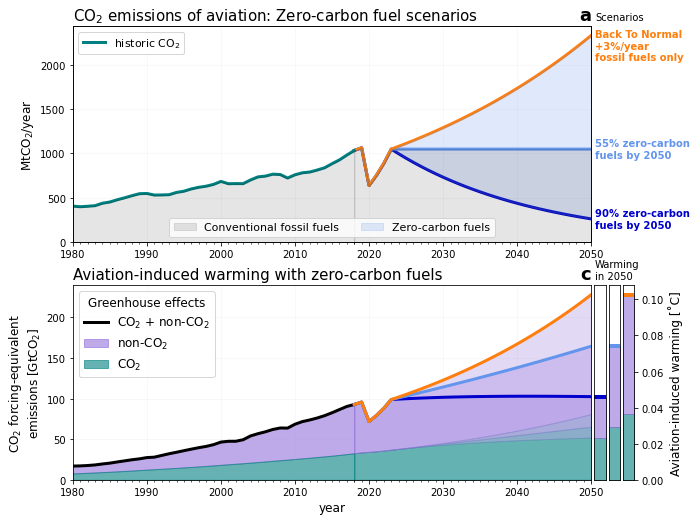

In [36]:
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_axes([0,0.55,0.9,0.5])
ax2 = ax1.twinx()
ax3 = fig.add_axes([0,0,0.9,0.45])

# scenario axes
pos = ax3.get_position()
ax_s1 = fig.add_axes([pos.x1+0.005,pos.y0,0.02,pos.y1-pos.y0])
ax_s2 = fig.add_axes([pos.x1+0.03,pos.y0,0.02,pos.y1-pos.y0])
ax_s3 = fig.add_axes([pos.x1+0.055,pos.y0,0.02,pos.y1-pos.y0])
ax_s3.yaxis.set_label_position("right")
ax_s3.yaxis.tick_right()

# future scenarios
ax2.fill_between(years,co2,alpha=0.1,color="k",label="Conventional fossil fuels")
ax2.fill_between(years_future,co2_scenario3,co2_scenario6,alpha=0.2,color="cornflowerblue",label="Zero-carbon fuels")
ax2.fill_between(years_future,co2_scenario5,alpha=0.1,color="k")

ax1.plot(years_future,co2_scenario6,"mediumblue",lw=3)
ax1.plot(years_future,co2_scenario5,"cornflowerblue",lw=3)
ax1.plot(years_future,co2_scenario3,"C1",lw=3)

# historic
ax1.plot(years,co2,"teal",lw=3,label=r"historic CO$_2$")

ax1.set_title(r"CO$_2$ emissions of aviation: Zero-carbon fuel scenarios",loc="left",fontsize=15)
ax1.set_title("a",loc="right",fontweight="bold",fontsize=18)
ax3.set_title("c",loc="right",fontweight="bold",fontsize=18)

ax1.set_ylabel(r"MtCO$_2$/year",fontsize=12)
ax1.set_xlim(1980,2050)
ax2.set_xlim(1980,2050)
ax3.set_xlim(1980,2050)
ax1.set_ylim(0,ax1.get_ylim()[1])
ax2.set_ylim(0,ax1.get_ylim()[1])
ax1.set_xticks(np.hstack((years,years_future)),minor=True)
ax3.set_xticks(np.hstack((years,years_future)),minor=True)
ax2.set_yticks([])

# FORCING-EQUIVALENT EMISSIONS AND WARMING
# historic
alfa=0.6
h3 = lambda y: 1-np.cbrt(1-y)
h4 = lambda y: 1-np.sqrt(np.sqrt(1-y))  # four-level superimposed alpha

# cumulative
ax3.fill_between(years,nonCO2_cumemissions+cumco2_1940,cumco2_1940,alpha=alfa,color="mediumpurple",label="non-CO$_2$")
ax3.fill_between(years,cumco2_1940,alpha=alfa,color="teal",label=r"CO$_2$")
ax3.plot(years,nonCO2_cumemissions+cumco2_1940,"k",lw=3,label=r"CO$_2$ + non-CO$_2$")

# cumulative future
# CO2
# ax3.fill_between(years_future,np.ones_like(years_future)*np.sum(co2)/1000,alpha=h4(alfa),color="teal")
ax3.fill_between(years_future,np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario6)/1000,
                 alpha=h3(alfa),color="teal")
ax3.fill_between(years_future,np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario5)/1000,
                 alpha=h3(alfa),color="teal")
ax3.fill_between(years_future,np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000,
                 alpha=h3(alfa),color="teal")

# ax3.plot(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario6)/1000,"mediumblue")
# ax3.plot(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario5)/1000,"cornflowerblue")
# ax3.plot(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario3)/1000,"C1")

# NON-CO2
ax3.plot(years_future,nonco2_cumemiss_scenario3+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000,
         "C1",lw=3,zorder=10)
ax3.plot(years_future,nonco2_cumemiss_scenario5+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario5)/1000,
         "cornflowerblue",lw=3,zorder=9)
ax3.plot(years_future,nonco2_cumemiss_scenario6+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario6)/1000,
         "mediumblue",lw=3,zorder=8)

ax3.fill_between(years_future,nonco2_cumemiss_scenario5+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario5)/1000,
                 np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario5)/1000,
                 alpha=h3(alfa),color="mediumpurple")
ax3.fill_between(years_future,nonco2_cumemiss_scenario6+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario6)/1000,
                 np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario6)/1000,
                 alpha=h3(alfa),color="mediumpurple")
ax3.fill_between(years_future,nonco2_cumemiss_scenario3+np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000,
                 np.sum(co2_1940[:-1])/1000+np.cumsum(co2_scenario3)/1000,
                 alpha=h3(alfa),color="mediumpurple")

# SCENARIO COMPARISON 2050
ax_s1.axhline(warming_scenario6[-1],color="mediumblue",lw=4)
ax_s2.axhline(warming_scenario5[-1],color="cornflowerblue",lw=4)
ax_s3.axhline(warming_scenario3[-1],color="C1",lw=4)

ax_s1.fill_between([0,1],np.ones(2)*co2warm_scenario6[-1],color="teal",alpha=alfa)
ax_s2.fill_between([0,1],np.ones(2)*co2warm_scenario5[-1],color="teal",alpha=alfa)
ax_s3.fill_between([0,1],np.ones(2)*co2warm_scenario3[-1],color="teal",alpha=alfa)

ax_s1.fill_between([0,1],np.ones(2)*warming_scenario6[-1],np.ones(2)*co2warm_scenario6[-1],color="mediumpurple",alpha=alfa)
ax_s2.fill_between([0,1],np.ones(2)*warming_scenario5[-1],np.ones(2)*co2warm_scenario5[-1],color="mediumpurple",alpha=alfa)
ax_s3.fill_between([0,1],np.ones(2)*warming_scenario3[-1],np.ones(2)*co2warm_scenario3[-1],color="mediumpurple",alpha=alfa)

ax3.set_title(r"Aviation-induced warming with zero-carbon fuels",loc="left",fontsize=15)
ax3.set_ylabel(r"CO$_2$ forcing-equivalent"+"\n"+"emissions [GtCO$_2$]",fontsize=12)
ax_s3.set_ylabel("Aviation-induced warming [˚C]",fontsize=12)
ax3.set_xlabel("year",fontsize=12)
ax1.legend(loc=2,fontsize=11)
ax2.legend(loc=8,fontsize=11,ncol=2)
ax3.legend(loc=2,title="Greenhouse effects",fontsize=12,title_fontsize='large')

ax3.set_ylim(0,ax3.get_ylim()[1])
for ax in [ax_s1,ax_s2,ax_s3]:
    ax.set_ylim(0,TCRE*ax3.get_ylim()[1])
    ax.set_xlim(0,1)

for ax in [ax_s1,ax_s2]:
    ax.set_yticks([])
    ax.set_xticks([])

ax_s3.set_xticks([])

ax1.grid(alpha=0.1)
ax3.grid(alpha=0.1)

ax1.text(2050.5,ax1.get_ylim()[1]*1.03,"Scenarios")
ax3.text(2050.5,ax3.get_ylim()[1]*1.035,"Warming\nin 2050")
ax1.text(2050.5,co2_scenario3[-1]*0.95,"Back To Normal\n+3%/year\nfossil fuels only",color="C1",fontweight="bold",va="center")
ax1.text(2050.5,co2_scenario5[-1],str(int(np.round((1-m5[-1])*20)*5))+"% zero-carbon\nfuels by 2050",color="cornflowerblue",fontweight="bold",va="center")
ax1.text(2050.5,co2_scenario6[-1],str(int(np.round((1-m6[-1])*20)*5))+"% zero-carbon\nfuels by 2050",color="mediumblue",fontweight="bold",va="center");

# plt.savefig("../plots/biofuels_warming.pdf")

In [34]:
np.diff(co2_scenario3-co2_scenario6)/3.16

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       26.57248508, 26.04103538, 25.5600734 , 25.12779221, 24.74249676,
       24.4025989 , 24.10661275, 23.85315021, 23.64091685, 23.46870788,
       23.33540447, 23.23997018, 23.18144769, 23.1589556 , 23.17168553,
       23.21889929, 23.2999263 , 23.41416112, 23.56106114, 23.74014439,
       23.95098758, 24.19322411, 24.4665424 , 24.77068416, 25.10544289,
       25.47066248, 25.86623584])